In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, auc, accuracy_score, precision_score, recall_score,
                             matthews_corrcoef, f1_score, average_precision_score,
                             cohen_kappa_score, log_loss)
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the dataset into a Pandas DataFrame
credit_card_data = pd.read_csv('Downloads/creditcard_2023.csv')

In [3]:
X = credit_card_data.drop(columns='Class', axis=1)
Y = credit_card_data['Class']

In [4]:
# Optionally scale features for better model performance
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [5]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [6]:
# Initialize SGD and AdaBoost models
sgd_model = SGDClassifier(loss='log_loss', max_iter=10000, random_state=42)
adaboost_model = AdaBoostClassifier(n_estimators=50, random_state=42)

In [7]:
# Start timer
start_time = time.time()

# Train both models
sgd_model.fit(X_train, Y_train)
adaboost_model.fit(X_train, Y_train)

# End timer
end_time = time.time()
training_time = end_time - start_time
print(f"Time taken to train both models: {training_time:.2f} seconds")

Time taken to train both models: 146.20 seconds


In [8]:
# Start timer
start_time = time.time()

# Make predictions
sgd_preds = sgd_model.predict_proba(X_test)[:, 1]  # Probability scores from SGD
adaboost_preds = adaboost_model.predict_proba(X_test)[:, 1]  # Probability scores from AdaBoost

# Hybrid Model: Weighted Averaging
alpha = 0.5  # Weight for SGD (Better Generalization)
beta = 0.5  # Weight for AdaBoost (Better Accuracy)
hybrid_preds = (alpha * sgd_preds) + (beta * adaboost_preds)

# Convert probabilities to class labels (Threshold = 0.5)
hybrid_preds_class = (hybrid_preds >= 0.5).astype(int)

# End timer
end_time = time.time()
training_time = end_time - start_time
print(f"Time taken to train both models: {training_time:.2f} seconds")

Time taken to train both models: 0.29 seconds


In [9]:
# Start timer
start_time = time.time()

# Get probability predictions for training data
sgd_train_preds = sgd_model.predict_proba(X_train)[:, 1]
adaboost_train_preds = adaboost_model.predict_proba(X_train)[:, 1]

# Hybrid Model: Weighted Averaging on Training Data
hybrid_train_preds = (alpha * sgd_train_preds) + (beta * adaboost_train_preds)

# Convert probabilities to class labels (Threshold = 0.5)
hybrid_train_preds_class = (hybrid_train_preds >= 0.5).astype(int)

# End timer
end_time = time.time()
training_time = end_time - start_time
print(f"Time taken to train both models: {training_time:.2f} seconds")

Time taken to train both models: 0.96 seconds


In [10]:
# Training Accuracy
training_accuracy = accuracy_score(Y_train, hybrid_train_preds_class)
print(f"Training Accuracy: {training_accuracy:.4f}")

Training Accuracy: 0.9988


In [11]:
# Testing Accuracy
test_accuracy = accuracy_score(Y_test, hybrid_preds_class)
print(f"Testing Accuracy: {test_accuracy:.4f}")

Testing Accuracy: 0.9987



Hybrid Model Confusion Matrix:
 [[56824    39]
 [  106 56757]]


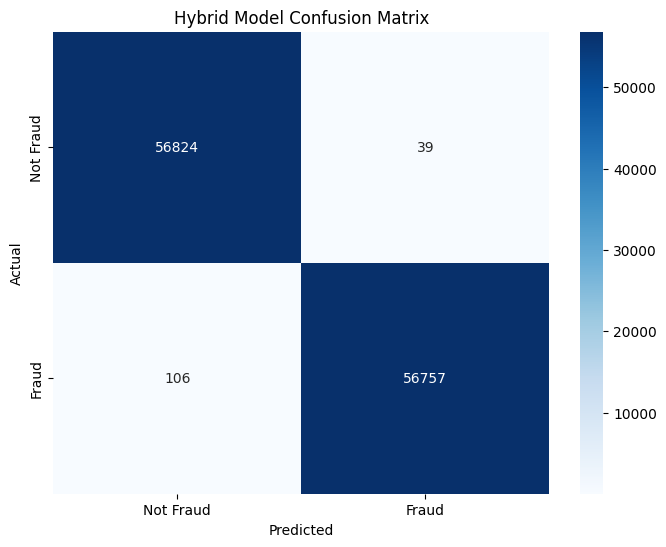

In [12]:
# Compute confusion matrix for hybrid model
conf_matrix = confusion_matrix(Y_test, hybrid_preds_class)
print("\nHybrid Model Confusion Matrix:\n", conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Hybrid Model Confusion Matrix')
plt.show()

In [13]:
TN, FP, FN, TP = conf_matrix.ravel()

In [14]:
# Calculate basic derived metrics
sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0  
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0  
precision = TP / (TP + FP) if (TP + FP) != 0 else 0      
mcc = matthews_corrcoef(Y_test, hybrid_preds_class)                  
BCR = (sensitivity + specificity) / 2                    

In [15]:
# Calculate additional metrics
f1 = f1_score(Y_test, hybrid_preds_class)                            
avg_precision = average_precision_score(Y_test, hybrid_preds)  
kappa = cohen_kappa_score(Y_test, hybrid_preds_class)                
logloss = log_loss(Y_test, hybrid_preds)  

In [16]:
print("\nDerived Metrics:")
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)
print("F1 Score:", f1)
print("MCC:", mcc)
print("BCR:", BCR)
print("Average Precision (AUC-PR):", avg_precision)
print("Cohen's Kappa:", kappa)
print("Log Loss:", logloss)


Derived Metrics:
Sensitivity (Recall): 0.9981358704254084
Specificity: 0.9993141410055748
Precision: 0.9993133319247834
F1 Score: 0.9987242541285776
MCC: 0.9974507038223822
BCR: 0.9987250057154916
Average Precision (AUC-PR): 0.9999727984845669
Cohen's Kappa: 0.9974500114309832
Log Loss: 0.14225617263183069


In [17]:
# Compute ROC AUC for hybrid model
roc_auc = roc_auc_score(Y_test, hybrid_preds)
print(f"\nHybrid Model ROC AUC: {roc_auc:.4f}")


Hybrid Model ROC AUC: 1.0000


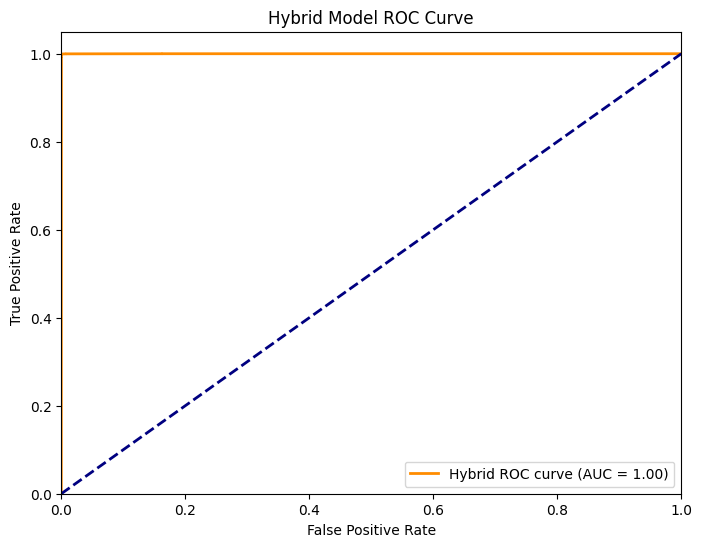

In [18]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, hybrid_preds)
roc_auc_val = auc(fpr, tpr)
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Hybrid ROC curve (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid Model ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [19]:
# Find Optimal Threshold
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold (Youden's Index):", optimal_threshold)

Optimal Threshold (Youden's Index): 0.44907465794571944


In [20]:
# Recalculate predictions using the optimal threshold
Y_pred_optimal = (hybrid_preds >= optimal_threshold).astype(int)
opt_conf_matrix = confusion_matrix(Y_test, Y_pred_optimal)
opt_accuracy = accuracy_score(Y_test, Y_pred_optimal)
print("\nMetrics with Optimal Threshold:")
print("Optimal Test Accuracy:", opt_accuracy)
print("Optimal Confusion Matrix:")
print(opt_conf_matrix)


Metrics with Optimal Threshold:
Optimal Test Accuracy: 0.9989184531241756
Optimal Confusion Matrix:
[[56805    58]
 [   65 56798]]


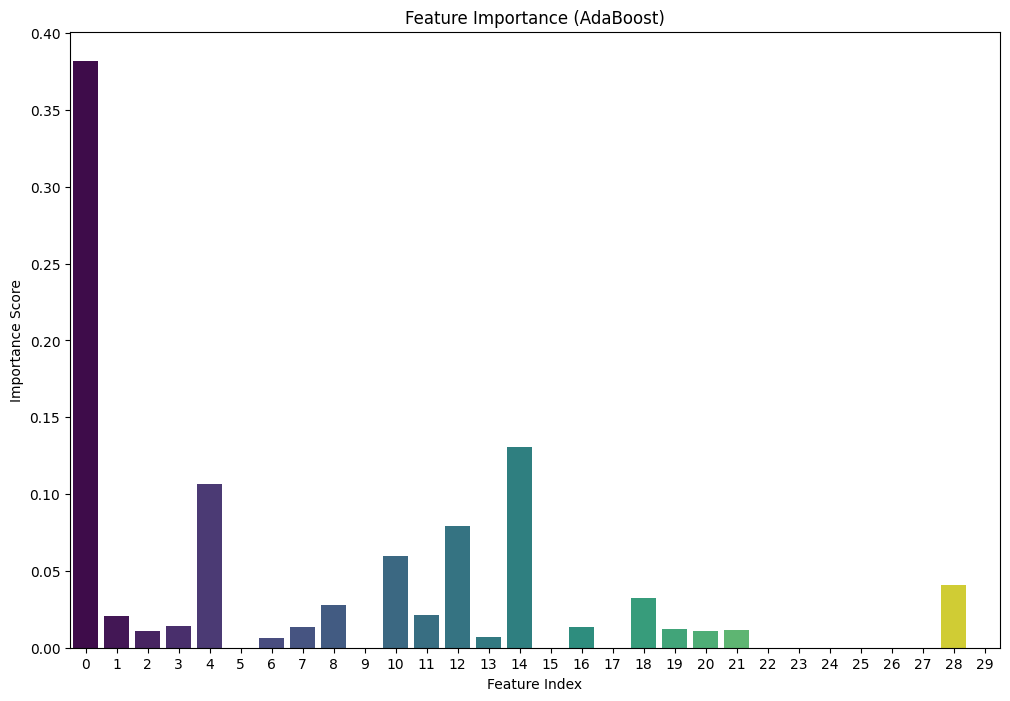

In [21]:
# -----------------------------------------------------------
feature_importance = adaboost_model.feature_importances_
plt.figure(figsize=(12, 8))
sns.barplot(x=np.arange(len(feature_importance)), y=feature_importance, hue=np.arange(len(feature_importance)), palette='viridis', legend=False)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.title("Feature Importance (AdaBoost)")
plt.show()

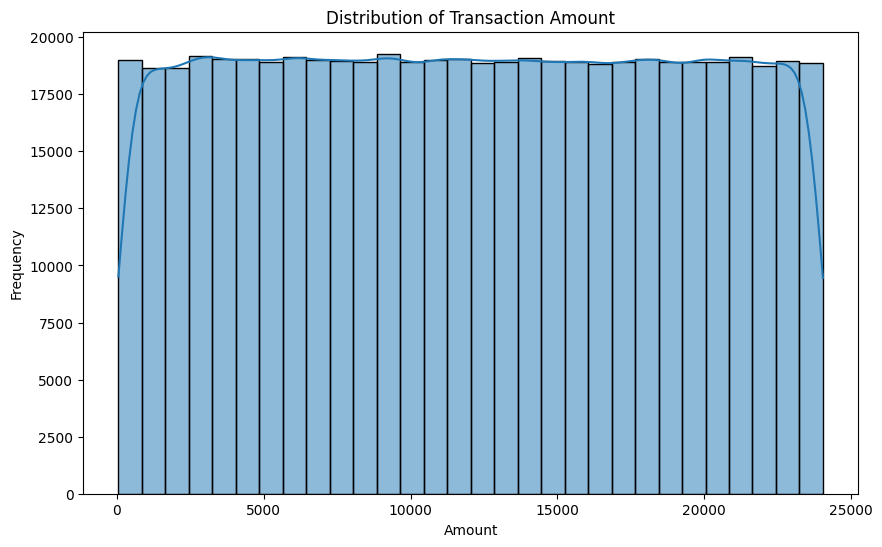

In [22]:
# Distribution of Transaction Amount
plt.figure(figsize=(10, 6))
sns.histplot(credit_card_data['Amount'], kde=True, bins=30)
plt.title('Distribution of Transaction Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

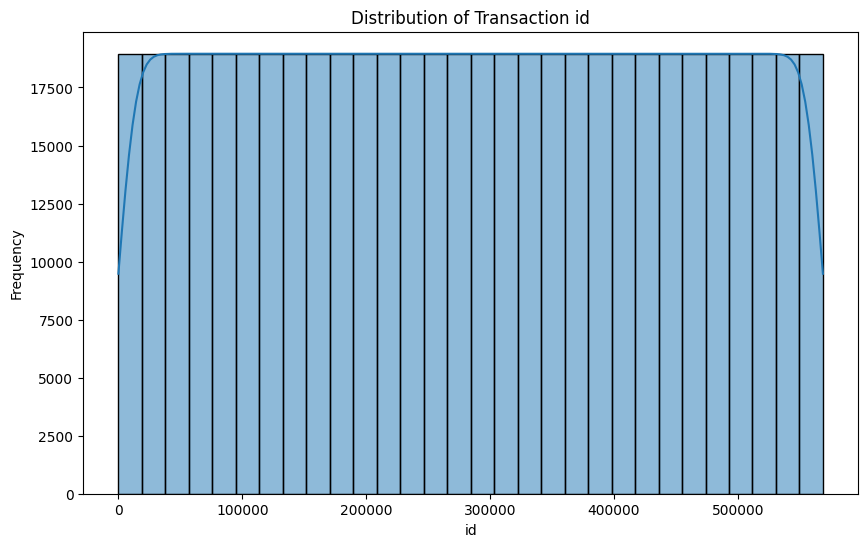

In [23]:
# Distribution of Transaction ID (handle infinite values)
credit_card_data['id'] = credit_card_data['id'].replace([np.inf, -np.inf], np.nan)
plt.figure(figsize=(10, 6))
sns.histplot(credit_card_data['id'], kde=True, bins=30)
plt.title('Distribution of Transaction id')
plt.xlabel('id')
plt.ylabel('Frequency')
plt.show()

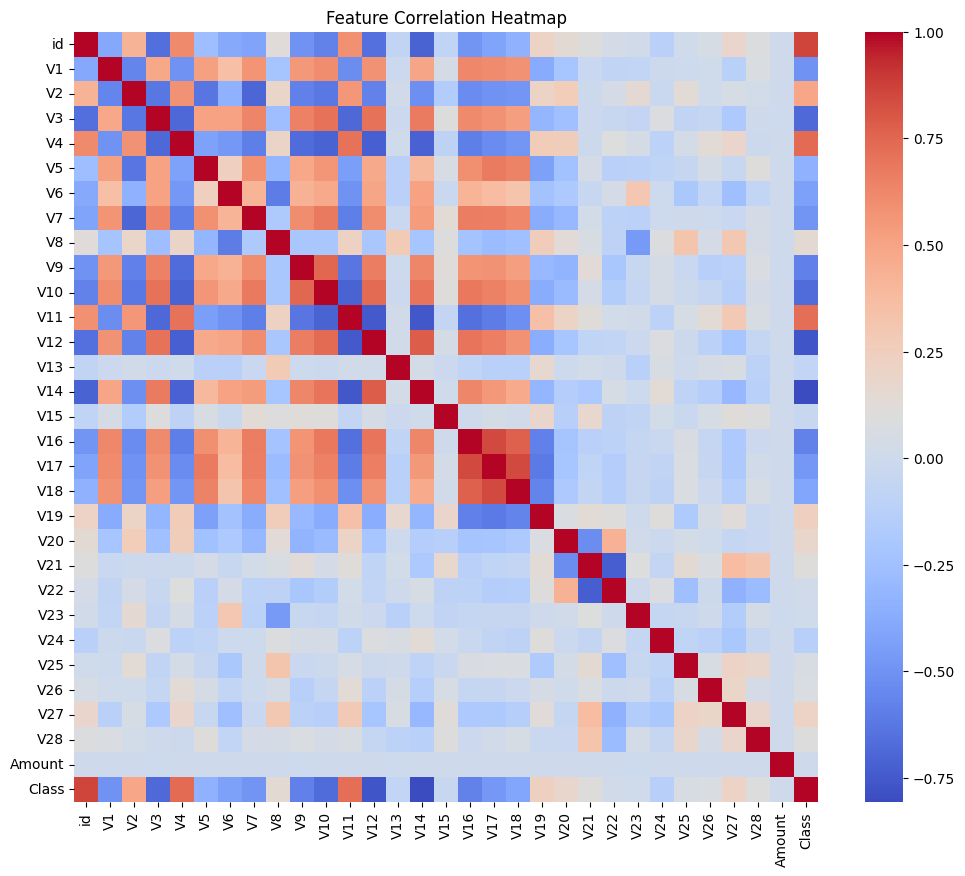

In [24]:
# Correlation Heatmap
plt.figure(figsize=(12, 10))
corr = credit_card_data.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [25]:
# Create a dictionary to store evaluation metrics for this model.
results = {}
results["SGDClassifier"] = {
    "Training Accuracy": training_accuracy,
    "Test Accuracy": test_accuracy,
    "Optimal Test Accuracy": opt_accuracy,
    "Sensitivity": sensitivity,
    "Specificity": specificity,
    "Precision": precision,
    "F1 Score": f1,
    "MCC": mcc,
    "BCR": BCR,
    "ROC AUC": roc_auc,
    "Average Precision": avg_precision,
    "Cohen's Kappa": kappa,
    "Log Loss": logloss,
    "Training Time (s)": training_time,
    "Optimal Threshold": optimal_threshold
}

In [26]:
results_df = pd.DataFrame(results).T  # Transpose so each row represents a model
print("\nComparison Table of Evaluation Metrics:")
print(results_df)


Comparison Table of Evaluation Metrics:
               Training Accuracy  Test Accuracy  Optimal Test Accuracy  \
SGDClassifier           0.998754       0.998725               0.998918   

               Sensitivity  Specificity  Precision  F1 Score       MCC  \
SGDClassifier     0.998136     0.999314   0.999313  0.998724  0.997451   

                    BCR   ROC AUC  Average Precision  Cohen's Kappa  Log Loss  \
SGDClassifier  0.998725  0.999965           0.999973        0.99745  0.142256   

               Training Time (s)  Optimal Threshold  
SGDClassifier           0.960215           0.449075  
